This is a simplified version of the vera_rubin code released solely as an example case for the 2023 anankethon. 

# Load FIRE Data

The data used is from the FIRE 2 data release, and is interpretted via the gizmo_analysis library. \
More information on FIRE can be found here: http://flathub.flatironinstitute.org/fire \
The gizmo_analysis library can be found here: https://bitbucket.org/awetzel/gizmo_analysis/src/master/

In [2]:
# Import the main analysis module
import gizmo_analysis as gizmo

In [3]:
# Choose the simulation directory
simulation_directory = '/home/jovyan/fire2/m12i'

In [4]:
# Read star particles and gas cells at z = 0
# use particle_subsample_factor to periodically sub-sample particles, to save memory
part = gizmo.io.Read.read_snapshots(['star', 'gas' ], 'redshift', 0, simulation_directory, particle_subsample_factor=10)


# in utilities.simulation.Snapshot():
* reading:  Volumes/Haven/m12i_res7100/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  Volumes/Haven/m12i_res7100/output/snapdir_600/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 57060074 particles
    star      (id = 4): 13976485 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star', 'gas']

* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5

! cannot find MUSIC config file:  Volumes/Haven/m12i_res7100/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* periodically subsampling all particles 

# Sample Image

In [5]:
# Import matplotlib and numpy libraries
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [6]:
# These are coordinates relative to the central galaxy
coordinates = part['gas'].prop( 'host.distance' )

# This is distance to the center of the central galaxy
distance_to_center = part['gas'].prop( 'host.distance.total' )

# An approximate definition for being in the galaxy: particles within 10 kpc of the center
is_in_galaxy = distance_to_center < 10.

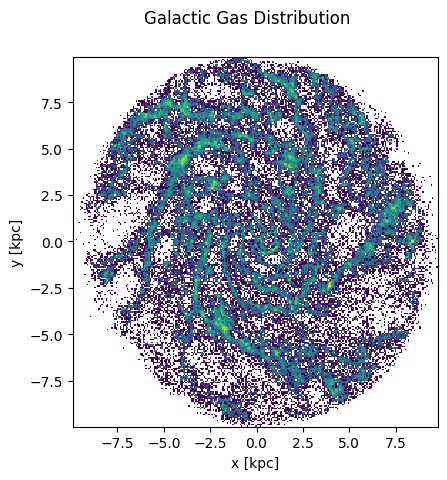

In [7]:
# Plot the logarithmically normalized count of the gas particles at each coordinate
fig = plt.figure()
ax = plt.gca()

# Use 2-D histogram
ax.hist2d(
    coordinates[:,0][is_in_galaxy],
    coordinates[:,1][is_in_galaxy],
    bins = 256,
    norm = matplotlib.colors.LogNorm(),
)

# Add labels, aspect ration, and title
ax.set_xlabel( r'x [kpc]' )
ax.set_ylabel( r'y [kpc]' )
ax.set_aspect( 'equal' )
fig.suptitle("Galactic Gas Distribution");

# Ananke

In [ ]:
# Import ananke library
import ananke as an

In [14]:
# Create p dictionary to store particle data
p = {}
p['pos3'] = part['star'].prop('host.distance')       # position in kpc
p['vel3'] = part['star'].prop('host.velocity')       # velocity in km/s
p['mass'] = part['star']['mass']                     # mass in solar masses
p['age'] = part['star'].prop('age')                  # log age in Gyr
p['feh'] = part['star'].prop('metallicity.fe')       # [Fe/H]
p['helium'] = part['star'].prop('metallicity.he')    # [He/H]
p['carbon'] = part['star'].prop('metallicity.c')     # [C/H]
p['nitrogen'] = part['star'].prop('metallicity.n')   # [N/H]
p['neon'] = part['star'].prop('metallicity.ne')      # [Ne/H]
p['magnesium'] = part['star'].prop('metallicity.mg') # [Mg/H]
p['silicon'] = part['star'].prop('metallicity.si')   # [Si/H]
p['sulphur'] = part['star'].prop('metallicity.s')    # [S/H]
p['calcium'] = part['star'].prop('metallicity.ca')   # [Ca/H]
p['oxygen'] = part['star'].prop('metallicity.o')     # [O/H]
p['alpha'] = part['star'].prop('metallicity.mg - metallicity.fe')          # [Mg/Fe]
p['parentid'] = part['star']['id']                   # indices of parent particles in snapshot
p['dform'] = np.zeros(part['star']['position'].shape[0], dtype='float32')  # dummy variable for now

A large portion of the keyword arguments are inherited by the Galaxia subprocess that ananke is built on, therefore, many can be found in the following Galaxia documentation: https://galaxia.sourceforge.net/Galaxia3pub.html#mozTocId450905

In [ ]:
# Run the ananke process with kword args
name='sim'
ananke = an.Ananke(p, name, fsample=0.01, photo_sys='padova/LSST', cmd_magnames='rmag,gmag-rmag'
                                            , app_mag_lim_lo=20, app_mag_lim_hi=24, abs_mag_lim_lo=-7.0, abs_mag_lim_hi=10.0
                                            , color_lim_lo=-1000, color_lim_hi=1000, surveyArea=360, r_max=1000
                                            , longitude=90, latitude=0)
ananke.run()

The output of the survey is in Vaex hybrid data frame, which you can read about here: https://vaex.readthedocs.io/en/latest/guides/data_types.html

In [2]:
# The outputed survey can be stored in a variable for further use
survey = ananke._output